In [1]:
import sim
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Actuator names
left_motor_name = "Pioneer_p3dx_leftMotor"
right_motor_name = "Pioneer_p3dx_rightMotor"

# Values to send  (rad/sec)
left_velocity = -1.0
right_velocity = 1.0


# Send the command!
print('Program started')
sim.simxFinish(-1)  # just in case, close all opened connections
clientID = sim.simxStart('127.0.0.1', 19999, True, True, 5000, 5)  # Connect to CoppeliaSim

if clientID != -1:
    print('Connected to remote API server')

    # Now try to retrieve data in a blocking fashion (i.e. a service call):
    res, objs = sim.simxGetObjects(clientID, sim.sim_handle_all, sim.simx_opmode_blocking)
    
    # Get handlers or actuators
    err_code, l_motor_handle = sim.simxGetObjectHandle(clientID, left_motor_name, sim.simx_opmode_blocking)
    err_code, r_motor_handle = sim.simxGetObjectHandle(clientID, right_motor_name, sim.simx_opmode_blocking)

    # Send the values!
    err_code = sim.simxSetJointTargetVelocity(clientID, l_motor_handle, left_velocity, sim.simx_opmode_streaming)
    err_code = sim.simxSetJointTargetVelocity(clientID, r_motor_handle, right_velocity, sim.simx_opmode_streaming)

    # Before closing the connection to CoppeliaSim, make sure that the last command sent out had time to arrive. You can guarantee this with (for example):
    sim.simxGetPingTime(clientID)

    # Now close the connection to CoppeliaSim:
    sim.simxFinish(clientID)
else:
    print('Failed connecting to remote API server')
print('Program ended')

Program started
Connected to remote API server
Program ended


In [3]:
class robot():
    
    def __init__(self, frame_name, motor_names=[], client_id=0):  
        # If there is an existing connection
        if client_id:
                self.client_id = client_id
        else:
            self.client_id = self.open_connection()
            
        self.motors = self._get_handlers(motor_names) 
        
        # Robot frame
        self.frame =  self._get_handler(frame_name)
            
        
    def open_connection(self):
        sim.simxFinish(-1)  # just in case, close all opened connections
        self.client_id = sim.simxStart('127.0.0.1', 19999, True, True, 5000, 5)  # Connect to CoppeliaSim 
        
        if clientID != -1:
            print('Robot connected')
        else:
            print('Connection failed')
        return clientID
        
    def close_connection(self):    
        sim.simxGetPingTime(self.client_id)  # Before closing the connection to CoppeliaSim, make sure that the last command sent out had time to arrive.
        sim.simxFinish(self.client_id)  # Now close the connection to CoppeliaSim:
        print('Connection closed')
    
    def isConnected(self):
        c,result = sim.simxGetPingTime(self.client_id)
        # Return true if the robot is connected
        return result > 0         
        
    def _get_handler(self, name):
        err_code, handler = sim.simxGetObjectHandle(self.client_id, name, sim.simx_opmode_blocking)
        return handler
    
    def _get_handlers(self, names):
        handlers = []
        for name in names:
            handler = self._get_handler(name)
            handlers.append(handler)
        
        return handlers

    def send_motor_velocities(self, vels):
        for motor, vel in zip(self.motors, vels):
            err_code = sim.simxSetJointTargetVelocity(self.client_id, 
                                                      motor, vel, sim.simx_opmode_streaming)      
            
    def set_position(self, position, relative_object=-1):
        if relative_object != -1:
            relative_object = self._get_handler(relative_object)        
        sim.simxSetObjectPosition(clientID, self.frame, relative_object, position, sim.simx_opmode_oneshot)
        
    def simtime(self):
        return sim.simxGetLastCmdTime(self.client_id)
    
    def get_position(self, relative_object=-1):
        # Get position relative to an object, -1 for global frame
        if relative_object != -1:
            relative_object = self._get_handler(relative_object)
        res, position = sim.simxGetObjectPosition(self.client_id, self.frame, relative_object, sim.simx_opmode_blocking)        
        return array(position)
    
    def get_object_position(self, object_name):
        # Get Object position in the world frame
        err_code, object_h = sim.simxGetObjectHandle(self.client_id, object_name, sim.simx_opmode_blocking)
        res, position = sim.simxGetObjectPosition(self.client_id, object_h, -1, sim.simx_opmode_blocking)
        return array(position)
    
    def get_object_relative_position(self, object_name):        
        # Get Object position in the robot frame
        err_code, object_h = sim.simxGetObjectHandle(self.client_id, object_name, sim.simx_opmode_blocking)
        res, position = sim.simxGetObjectPosition(self.client_id, object_h, self.frame, sim.simx_opmode_blocking)
        return array(position)

In [9]:
# Trajectory functions
def point_to_point_traj(x1, x2, v1, v2, delta_t):
  t = np.linspace(0, delta_t, 100)  
  a0 = x1
  a1 = v1
  a2 = (3*x2 - 3*x1 - 2*v1*delta_t - v2 * delta_t) / (delta_t**2)
  a3 = (2*x1 + (v1 + v2) * delta_t  - 2 * x2) / (delta_t**3)

  polynomial = a0 + a1 * t + a2 * t**2 + a3 * t**3
  derivative = a1 + 2*a2 * t + 3 * a3 * t**2
  return polynomial, derivative


def piecewise3D (X,Y, Z,Vx, Vy, Vz,T):
    theta_x, theta_y, theta_z, dx, dy,dz,time_s1 = [], [], [], [], [], [],[]

    for i in range(len(P)-1):          
        theta_xi, dxi = point_to_point_traj(X[i], X[i+1], Vx[i], Vx[i+1], T[i+1] - T[i])
        theta_yi, dyi = point_to_point_traj(Y[i], Y[i+1], Vy[i], Vy[i+1], T[i+1] - T[i])
        theta_zi, dzi = point_to_point_traj(Z[i], Z[i+1], Vz[i], Vz[i+1], T[i+1] - T[i])

        theta_x += theta_xi.tolist()
        theta_y += theta_yi.tolist()
        theta_z += theta_zi.tolist()
        dx += dxi.tolist()
        dy += dyi.tolist()
        dz += dzi.tolist()
        time_s1.append(T[i+1]-T[i])
        
        ax = plt.axes(projection='3d')
        plot(theta_xi, theta_yi,theta_zi)
    return theta_x, theta_y, theta_z,dx, dy,dz,time_s1

Robot connected
Connection closed


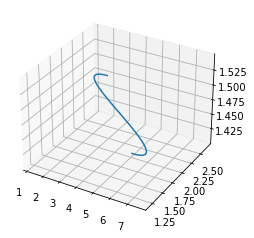

In [11]:
r = robot( frame_name='Quadricopter_target')

time_steps = linspace(0, 2*pi, 100)

p1 = r.get_position()
p2 = r.get_object_position('Sphere6')
p3 = r.get_object_position('Sphere5')
p4 = r.get_object_position('Sphere9')
p5 = r.get_object_position('Sphere8')
p6 =r.get_object_position('Sphere10') 
p7 = r.get_object_position('Sphere7')

v1 = [0,0,0]
v2 = [1,0,0]
v3 = [1,0,0]
v4 = [1,0,0]
v5 = [1,0,0]
v6 = [1,0,0]
v7 = [1,0,0]

t1 = 0
t2 = 10
t3 = 20
t4 = 30
t5 = 40
t6 = 50
t7 = 60


# Convert the initial conditions to a vector form
P = np.vstack((p1, p2, p3, p4, p5,p6,p7))
V = np.vstack((v1, v2, v3, v4, v5,v6,v7))
T = [t1, t2, t3, t4, t5,t6,t7]

X, Y ,Z= P[:,0], P[:,1],P[:,2]
Vx, Vy, Vz= V[:,0], V[:,1], V[:,2]

# Plot the trajectory that passes trhough the desired waypoints
theta_x, theta_y, theta_z,dx, dy,dz,time_s = piecewise3D(X,Y,Z, Vx, Vy,Vz, T)

for x, y,z,t in zip(theta_x, theta_y, theta_z,time_s):
    if r.client_id == -1:  # Check connection
        print('Robot is not connected')
        break
    
    #px, py = cos(t), sin(t)
    #robot_position = r.get_position()
    r.set_position([x,y,z])
    
    
    time.sleep(t)

    


r.close_connection()  # End